# Exploring & Testing FFT/Cross Correlation Algorithms & Associated Interopolation
## Sam Potter
## Current: 2/26/19

## Path and Imports

In [1]:
# bootstrap $PATH
import sys
import os
sys.path.extend(['C:\\Users\\potterst1\\Desktop\Repositories\BitBucket\dic',
                 'C:/Users/potterst1/Desktop/Repositories/BitBucket/dic'])
sys.path.extend(['/workspace/stpotter/git/bitbucket/dic'])
import warnings
from dic import nurbs
from dic import fileIO
from dic import numerics
from dic import analysis
from dic import image_processing
from dic import utilities
import cv2
from matplotlib import pyplot as plt
import numpy as np
from geomdl import BSpline as bs
from geomdl import utilities as gutil
import scipy.optimize as sciopt
import scipy.signal as sig
from scipy.ndimage import sobel
import numba
from numba import jit

## Magics

In [2]:
%matplotlib inline

### Read in ref image file

In [3]:
# Read
# Hard code absolute paths for now. Fix later'
dic_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = 'C:\\Users\\potterst1\\Desktop\\Repositories\\BitBucket\\dic\\data\\DOA_cropped_gray_pad_0.tiff'
dic_name = '/workspace/stpotter/git/bitbucket/dic/data/DIC_S_cropped_gray_pad_0.tiff'
psfdi_name = '/workspace/stpotter/git/bitbucket/dic/data/DOSA_cropped_gray_pad_0.tiff'
ref_image = cv2.imread(dic_name, -1)  # Read in image 'as is'
#ref_image = ref_image.astype(np.float)
#ref_image = ref_image.astype('uint8')

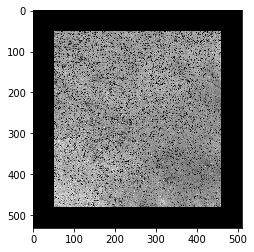

In [4]:
# Display
plt.imshow(ref_image, cmap='gray')

## Deform Ref Image

In [5]:
# Translate image in x
transx = np.array([[1.0, 0.0, 25.0],
                   [0.0, 1.0, 0.0]])
def_image = image_processing.im_warp(ref_image, transx)

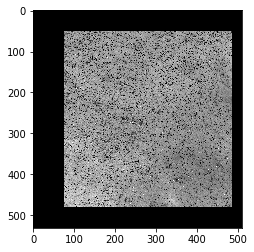

In [6]:
# Display
plt.imshow(def_image, cmap='gray')

## Manually Specify Region of Interest

In [7]:
# Format: [column index for start of X, column index for end of X, row index for start of Y, row index for end of Y]
subregion_indices = np.array([225, 275, 225, 275])

In [8]:
# Extract these regions from ref image and plot
ref_subimage = np.copy(ref_image[subregion_indices[2]:subregion_indices[3], subregion_indices[0]:subregion_indices[1]])

## Compute Cross Correlation

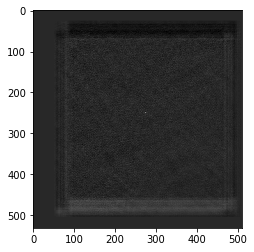

In [9]:
# normalize data
sub_normed = ref_subimage - ref_subimage.mean()
def_normed = def_image - def_image.mean()
foo = sig.correlate2d(def_normed, sub_normed, boundary='symm', mode='same')
plt.imshow(foo, cmap='gray')

In [10]:
bar = np.unravel_index(np.argmax(foo), foo.shape)
print(bar)

(249, 274)


In [11]:
sig.bspline(.4, 3)

array(0.53866667)

In [12]:
Q = np.array([[-1, 3, -3, 1],
             [3, -6, 3, 0],
             [-3, 0, 3, 0],
             [1, 4, 1, 0]])
c = np.ones(4)
b = np.matmul(Q, c)

x = np.array([0.4**3, .4**2, .4**1, 1])

val = np.inner(x, b) * 1/6
print(val)

1.0


In [13]:
ins = np.array([.2, .3, .4])
sig.cubic(ins)

array([0.63066667, 0.59016667, 0.53866667])

In [14]:
np.random.seed(0)
coeffs = np.random.randint(0, 255, size=((100, 100)))
x = 10.4
y = 10.2
order = 3

# Get the row and column start index based on x, y
colindex = np.ceil(x - (order + 1) / 2).astype('int')  # Cast to int
rowindex = np.ceil(y - (order + 1) / 2).astype('int')  # Cast to int

# Alias function
cubic = sig.cubic

val1 = 0.0
for k in range(rowindex, rowindex + order + 1):  # Adding one to account for range
    for l in range(colindex, colindex + order + 1):
        val1 += coeffs[k, l] * cubic(y - k) * cubic(x - l)
        
print('For loops: {}'.format(val1))

cols = np.array(range(colindex, colindex + order + 1))
rows = np.array(range(rowindex, rowindex + order + 1))
argx = x - cols
argy = y - rows
splinex = cubic(argx)
spliney = cubic(argy)

val2 = np.linalg.multi_dot((spliney, coeffs[rowindex: rowindex + order + 1, colindex: colindex + order + 1], splinex))

print('Matrix: {}'.format(val2))

For loops: 62.788896000000015
Matrix: 62.78889600000001


In [15]:
cols = np.array(range(rowindex, rowindex + order + 1))
print(cols)
argx = x - cols
cubic(argx)

[ 9 10 11 12]


array([0.036     , 0.53866667, 0.41466667, 0.01066667])

In [16]:
sig.bspline(.4, 3) * sig.bspline(.3, 3)

0.3179031111111112

In [17]:
sx = sobel(ref_image, axis=0, mode='constant')
sy = sobel(ref_image, axis=1, mode='constant')

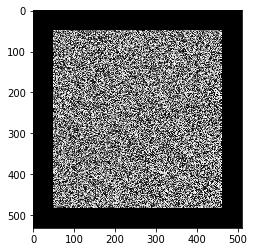

In [18]:
plt.imshow(sx, cmap='gray')

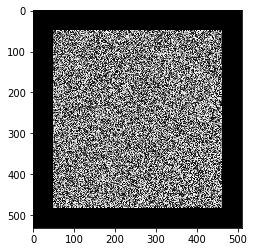

In [19]:
plt.imshow(sy, cmap='gray')

In [20]:
sxy = sobel(sy, axis=0, mode='constant')

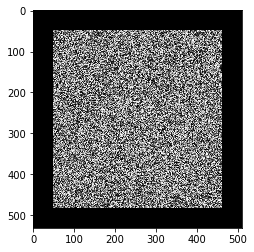

In [21]:
plt.imshow(sxy, cmap='gray')

In [22]:
print('sx: {}'.format(sx[100, 100]))
print('sy: {}'.format(sy[100, 100]))
print('sxy: {}'.format(sxy[100, 100]))

sx: 12594
sy: 31096
sxy: 44203


In [23]:
@jit(nopython=True, cache=True)
def testim(image, sx, sy, sxy):
    
    row, col = image.shape
    
    shape = ((row-1) * (col - 1), 4, 4)
    
    coeffs = np.zeros(shape, dtype=np.float64)
    
    C = np.array([[1., 0., 0., 0.],
                  [0., 0., 1., 0.],
                  [-3., 3., -2., -1.],
                  [2., -2., 1., 1.]])
    
    D = np.array([[1., 0., -3., 2.],
                  [0., 0., 3., -2.],
                  [0., 1., -2., 1.],
                  [0., 0., -1., 1.]])
    
    k = 0
    for j in range(0, col - 1):  # Move through x first, which is columns
        for i in range(0, row - 1):  # Move through y next, which is rows
            # Transpose sub-matrices because equation expects top row to be (0, 0), (0, 1) bot row (1, 0), (1, 1)
            F = np.vstack((np.hstack((ref_image[i:i+2, j:j+2].T, sy[i:i+2, j:j+2].T)), 
                           np.hstack((sx[i:i+2, j:j+2].T, sxy[i:i+2, j:j+2].T))))
                       
            A = C @ F @ D

            coeffs[k, :, :] = A
            
            k+=1

    return coeffs


In [24]:
testinterp = testim(ref_image.astype(np.float64), sx.astype(np.float64), sy.astype(np.float64), sxy.astype(np.float64))

In [25]:
%timeit testinterp = testim(ref_image.astype(float), sx.astype(float), sy.astype(float), sxy.astype(float))

358 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
def evalinterp(coeffs, x, y, shape):
    
    row = int(np.floor(y))
    col = int(np.floor(x))
    
    rows = shape[0] - 1
    cols = shape[1] - 1
    
    xval = x % 1.0
    yval = y % 1.0
    
    A = coeffs[col * rows + row, :, :]
    
    # Switch x and y because of the image coord sys
    
    xar = np.array([1.0, xval, xval ** 2, xval ** 3])
    yar = np.array([1.0, yval, yval ** 2, yval ** 3])
    
    p = yar @ A @ xar
    
    return p

In [27]:
%timeit testeval = evalinterp(testinterp, 100, 100, ref_image.shape)

15.6 µs ± 135 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [28]:
print(ref_image[100:102, 100:102])

[[44975 45232]
 [40092 38550]]


In [29]:
print(evalinterp(testinterp, 100, 100, ref_image.shape))
print(evalinterp(testinterp, 101, 100, ref_image.shape))
print(evalinterp(testinterp, 100, 101, ref_image.shape))
print(evalinterp(testinterp, 101, 101, ref_image.shape))

44975.0
45232.0
40092.0
38550.0
